# Bring Cluster

In [1]:
#%matplotlib widget
import torch
import numpy as np
from joblib import dump, load

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from bring_features_and_file_paths import bring_features_and_file_paths, transform_features

In [2]:
cluster_number = 0

## Bring all the features and file paths

In [3]:
features, file_paths, indices = bring_features_and_file_paths('/grand/projects/BirdAudio/Soundscapes/Features', sub_sample=0.99)
#features, file_paths, indices = bring_features_and_file_paths('/grand/projects/BirdAudio/Soundscapes/Second_Features', sub_sample=0.1)

We have 100065 feature vectors.


Now, we want to transform the features, scaling them and reducing their dimensionality

In [4]:
dim_red_model = load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/dim_red_model')
scale_model = load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/scale_model')

In [5]:
samples = transform_features(features, scale_model, dim_red_model)
samples.shape

(100065, 2)

Load the clusters generated from the features

We will use them to classify our sample of features now

In [6]:
clusters = np.load('/grand/projects/BirdAudio/Soundscapes/Clusters/ThirdClusters/clusters.npy', allow_pickle=True)
vectors=clusters[()]['x']
labels=clusters[()]['y']

In [7]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 100
Estimated number of noise points: 0


In [8]:
def choose_random_rows(an_array, n_samples):
    number_of_rows = an_array.shape[0]
    random_indices = np.random.choice(number_of_rows, size=n_samples, replace=False)
    random_rows = an_array[random_indices, :]
    return random_rows

X = choose_random_rows(vectors,5000)
n_components=X.shape[1]

Train a k-nearest neighbor algorithm to predict the samples

In [9]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(vectors, labels)

KNeighborsClassifier(n_neighbors=10)

In [10]:
label_predictions=neigh.predict(samples)
core_samples = np.zeros_like(label_predictions, dtype=bool)
core_samples[label_predictions == cluster_number] = True
n_noise_points = list(label_predictions).count(-1)

In [11]:
samples = samples[core_samples]

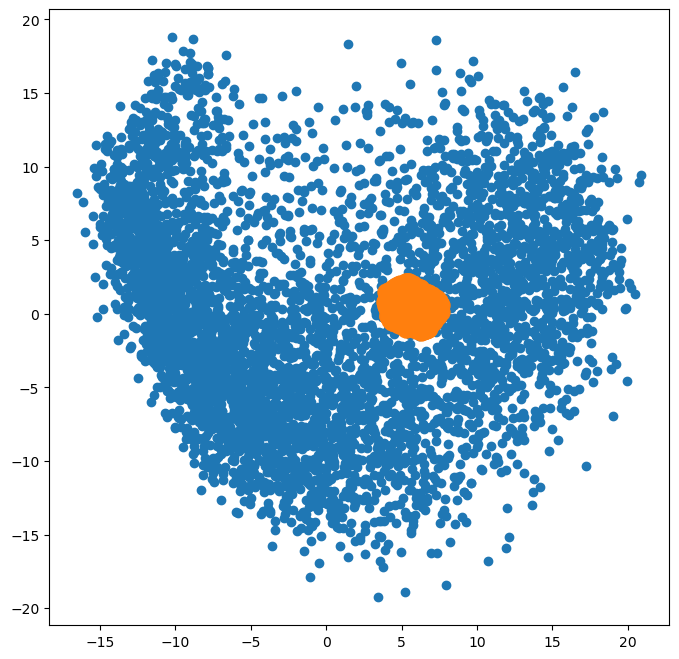

In [12]:
if n_components == 2:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    ax.scatter(X[:,0],X[:,1])
    ax.scatter(samples[:,0],
               samples[:,1],
               s=150
              )
elif n_components == 3:
    fig = plt.figure(figsize=(8,8))
    #ax = fig.add_subplot(projection='3d')
    ax = Axes3D(fig)
    ax.scatter(X[:,0], X[:,1], X[:,2])
    ax.scatter(
        samples[:,0],
        samples[:,1],
        samples[:,2],
        s=60
    )

In [13]:
torch.save(indices[core_samples], '/grand/projects/BirdAudio/Soundscapes/Indices/indices.pth')